In [60]:
import geopandas as gpd
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point

In [2]:
from greedy import greedy

In [48]:
sns.set()

In [50]:
polys = []
for x in range(10):
    for y in range(10):
        polys.append(Point(x, y).buffer(0.5, cap_style=3))
gdf = gpd.GeoDataFrame(geometry=polys)

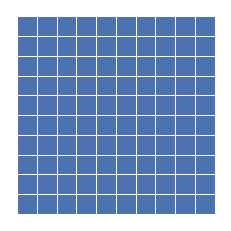

In [51]:
ax = gdf.plot(edgecolor='w')
ax.set_axis_off()

In [ ]:
libpysal based

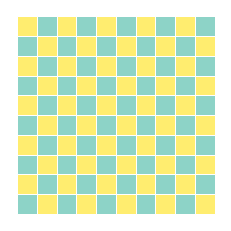

In [52]:
gdf['rook'] = greedy(gdf, sw='rook', min_colors=2)
ax = gdf.plot('rook', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

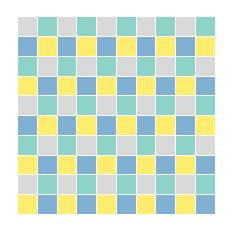

In [53]:
gdf['queen'] = greedy(gdf, sw='queen', min_colors=2)
ax = gdf.plot('queen', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

In [ ]:
intersection based

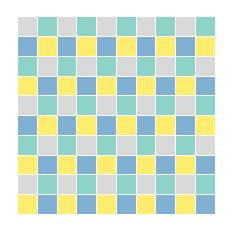

In [54]:
gdf['geos'] = greedy(gdf, min_distance=0, min_colors=2)
ax = gdf.plot('geos', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

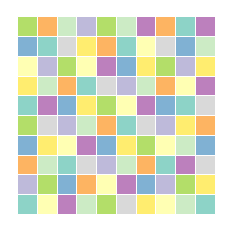

In [55]:
gdf['dist1'] = greedy(gdf, min_distance=1, min_colors=2)
ax = gdf.plot('dist1', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

In [28]:
times = pd.DataFrame(index=['rook', 'queen', 'geos', 'dist1'])
for number in range(10, 110, 10):
    print(number)
    polys = []
    for x in range(number):
        for y in range(number):
            polys.append(Point(x, y).buffer(0.5, cap_style=3))
    gdf = gpd.GeoDataFrame(geometry=polys)
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, sw='rook')
        e = time() - s
        timer.append(e)
    times.loc['rook', number] = np.mean(timer)
    print('rook: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, sw='queen')
        e = time() - s
        timer.append(e)
    times.loc['queen', number] = np.mean(timer)
    print('queen: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, min_distance=0)
        e = time() - s
        timer.append(e)
    times.loc['geos', number] = np.mean(timer)
    print('geos: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, min_distance=1)
        e = time() - s
        timer.append(e)
    times.loc['dist1', number] = np.mean(timer)
    print('dist1: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')


10
rook:  0.01029210090637207 s;  4 colors
queen:  0.006267690658569336 s;  4 colors
geos:  0.15672893524169923 s;  4 colors
dist1:  0.21950168609619142 s;  10 colors
20
rook:  0.01932358741760254 s;  4 colors
queen:  0.019013690948486327 s;  4 colors
geos:  0.5995094776153564 s;  4 colors
dist1:  0.9240117073059082 s;  10 colors
30
rook:  0.04496006965637207 s;  4 colors
queen:  0.04180002212524414 s;  4 colors
geos:  1.3673813819885254 s;  4 colors
dist1:  2.1132378578186035 s;  10 colors
40
rook:  0.08215422630310058 s;  4 colors
queen:  0.08703317642211914 s;  4 colors
geos:  2.4122870922088624 s;  4 colors
dist1:  3.9358083724975588 s;  10 colors
50
rook:  0.13613815307617189 s;  4 colors
queen:  0.1286477565765381 s;  4 colors
geos:  3.7892502784729003 s;  4 colors
dist1:  6.030300855636597 s;  10 colors
60
rook:  0.21495418548583983 s;  4 colors
queen:  0.20560770034790038 s;  4 colors
geos:  5.745699644088745 s;  4 colors
dist1:  8.623000431060792 s;  10 colors
70
rook:  0.3028

In [29]:
times

,10,20,30,40,50,60,70,80,90,100
rook,0.010292,0.019324,0.044960,0.082154,0.136138,0.214954,0.302874,0.389480,0.474235,0.587319
queen,0.006268,0.019014,0.041800,0.087033,0.128648,0.205608,0.270871,0.373657,0.437727,0.561277
geos,0.156729,0.599509,1.367381,2.412287,3.789250,5.745700,7.566798,10.271010,12.464201,15.281956
dist1,0.219502,0.924012,2.113238,3.935808,6.030301,8.623000,11.740410,15.380718,19.965695,24.670071


([<matplotlib.axis.XTick at 0x1201bfdf0>,
 <a list of 10 Text xticklabel objects>)

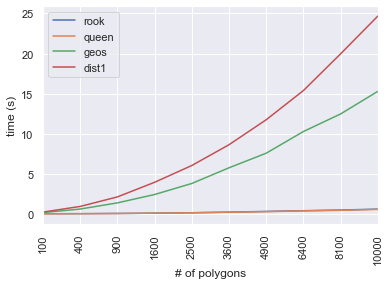

In [75]:
ax = times.T.plot()
ax.set_ylabel('time (s)')
ax.set_xlabel('# of polygons')
locs, labels = plt.xticks()
plt.xticks(locs, (times.columns ** 2), rotation='vertical')

([<matplotlib.axis.XTick at 0x11ff36a30>,
 <a list of 10 Text xticklabel objects>)

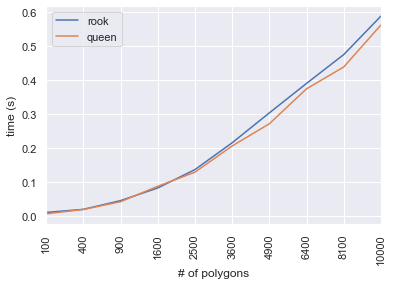

In [76]:
ax = times.loc[['rook', 'queen']].T.plot()
ax.set_ylabel('time (s)')
ax.set_xlabel('# of polygons')
locs, labels = plt.xticks()
plt.xticks(locs, (times.columns ** 2), rotation='vertical')